<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/11_K_means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-means Clustering**
- unsupervised learning algorithm that tries to cluster data based on their similarity (there are no labels; no target)
- tries to minimize the sum of squared distances from each
point to its cluster centroid|
- have to specify number of clusters we want the data to be grouped into
- "hard" and "flat" clustering method

***

**Summary**<br>
The algorithm randomly assigns each observation to a cluster, and finds the centroid of each cluster. Then, the algorithm iterates through two steps: Reassign data points to the cluster whose centroid is closest. Calculate new centroid of each cluster. These two steps are repeated till the within cluster variation cannot be reduced any further. The within cluster variation is calculated as the sum of the euclidean distance between the data points and their respective cluster centroids.

**Hard vs. Fuzzy Clustering**
- Hard = obs belong to one cluster
 - K-means, hierarchical, DBSCAN
- Fuzzy = obs can belong to more than one cluster
 - Fuzzy c-means, gaussian mixture models

**Flat vs. Hierarchical Clustering**
- Flat = clusters are formed via another process (ex/ iteratively updating cluster assignments)
- Hierarchical = clusters form a tree so that you can visualize which clusters are most similar to each other 


**Practical Applications**
- market segmentation
- medicine (ex/ tumor detection)
- fraud detection
- find topics in text data
- find communities in social networks
- dimension reduction
- simply identify clusters of customers within company or business

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
# !pip install kneed
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Import data and EDA

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/chelynl/ML_notes/main/clustering/Mall_Customers.csv?token=AMGO4MFUSIKY74WN2NH2P33A2CLCQ')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We want to use all features to identify any patterns/clusters in the data and then we can technically create a new target where values can be clusters themselves. Thus, customer ID would not be helpful since each observation will have a unique value.

However, for education purposes only and to visualize the clusters in a 2D plot, we will only work with 2 features (`Annual Income` and `Spending Score`) to identify the clusters.

In [4]:
# Define features to perform cluster analysis
X = df.iloc[:,3:].values

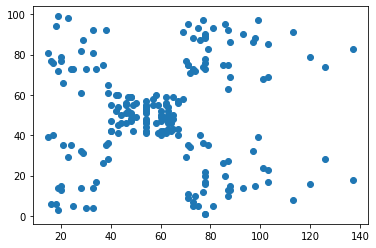

In [5]:
plt.scatter(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'])

## Find optimal number of clusters via Elbow method

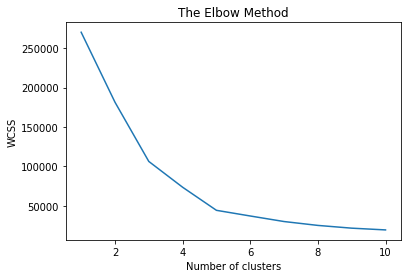

5

In [6]:
# List to store within cluster sum of squares
wcss = []

# Iterate over clusters 1-10 in KMeans model to find the optimal number
for i in range(1, 11):
  # ‘k-means++’ selects initial cluster centers for k-mean clustering in a smart way to speed up convergence (prevents random initialization trap)
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Identify the elbow point programmatically with kneed package
kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
kl.elbow # suggests 5 clusters

## Train K-Means model on data

In [7]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X) # cluster number, same as kmeans.labels_

In [8]:
df['Cluster'] = pd.Series(y_kmeans)

In [9]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,3
1,2,Male,21,15,81,0
2,3,Female,20,16,6,3
3,4,Female,23,16,77,0
4,5,Female,31,17,40,3


In [10]:
df.Cluster.value_counts()

1    81
2    39
4    35
3    23
0    22
Name: Cluster, dtype: int64

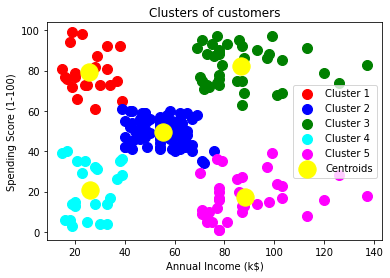

In [11]:
# Plot clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')

# Plot cluster centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

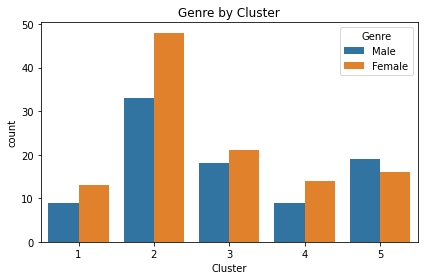

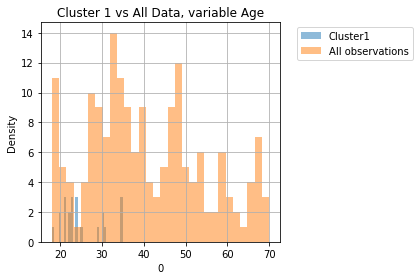

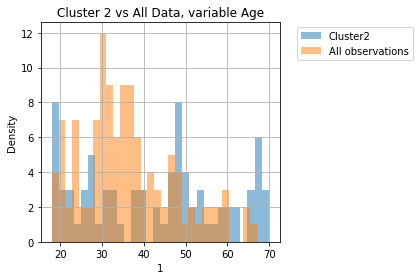

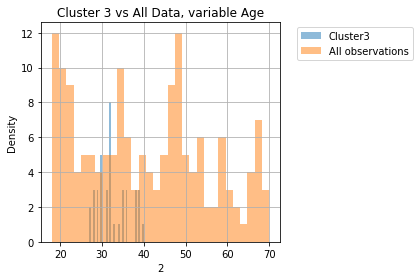

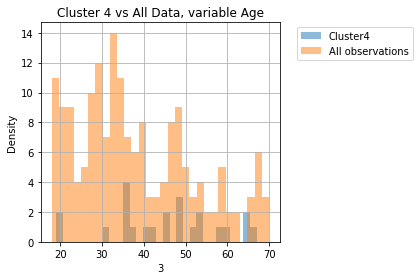

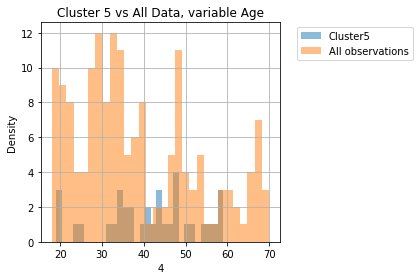

In [12]:
# Function to profile variables per cluster
def clusterProfile(df, clusterVar, varsToProfile):
    
    # Assign max cluster number to k
    k = int(df[clusterVar].max())+1
    
    # Loop through variables and check variable type
    for i in varsToProfile:
        
        # if numeric, make histogram
        if np.issubdtype(df[i].dtype, np.number):
            for j in range(0, k):
                df[df[clusterVar]==j][i].hist(alpha=0.5, bins=30, label=f'Cluster{j+1}')
                df[df[clusterVar]!=j][i].hist(alpha=0.5, bins=30, label='All observations')
                plt.title(f'Cluster {j+1} vs All Data, variable {i}')
                plt.xlabel(j)
                plt.ylabel('Density')
                plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
                plt.tight_layout()
                plt.show()
                
        # if categorical, make bar chart of level frequency
        if (df[i].dtype=='object') & (len(df[i].unique()) < 5):
            ax = sns.countplot(x="Cluster", hue=i, data=df)
            ax.set_xticklabels([1, 2, 3, 4, 5])
            plt.title(f'{i} by Cluster')
            plt.tight_layout()
            plt.show()
            
        
clusterProfile(df, 'Cluster', ['Genre', 'Age'])

# Example 2: Clustering College Data

In [63]:
df = pd.read_csv('https://raw.githubusercontent.com/chelynl/ML_notes/main/clustering/College_Data?token=AMGO4MH3737SHDPFZSDK7OLA2CM52', index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    object 
 1   Apps         777 non-null    int64  
 2   Accept       777 non-null    int64  
 3   Enroll       777 non-null    int64  
 4   Top10perc    777 non-null    int64  
 5   Top25perc    777 non-null    int64  
 6   F.Undergrad  777 non-null    int64  
 7   P.Undergrad  777 non-null    int64  
 8   Outstate     777 non-null    int64  
 9   Room.Board   777 non-null    int64  
 10  Books        777 non-null    int64  
 11  Personal     777 non-null    int64  
 12  PhD          777 non-null    int64  
 13  Terminal     777 non-null    int64  
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    int64  
 16  Expend       777 non-null    int64  
 17  Grad.Rate    777 non-null    int64  
dtypes: 

In [15]:
df.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000


## EDA

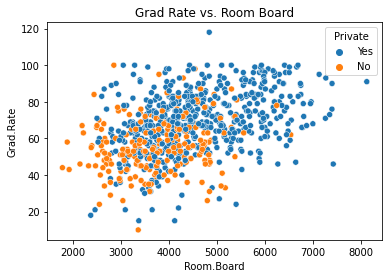

In [16]:
# Scatter plot of Grad.Rate versus Room.Board where the points are colored by the Private column
sns.scatterplot(x='Room.Board', y='Grad.Rate', hue='Private', data=df)
plt.title('Grad Rate vs. Room Board')
plt.show()

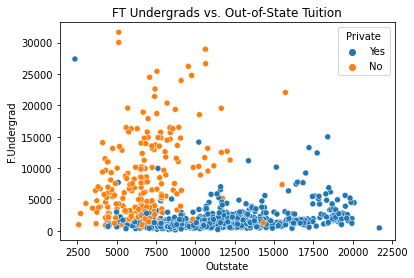

In [17]:
# Scatterplot of F.Undergrad versus Outstate where the points are colored by the Private column
sns.scatterplot(x='Outstate', y='F.Undergrad', hue='Private', data=df)
plt.title('FT Undergrads vs. Out-of-State Tuition')
plt.show()

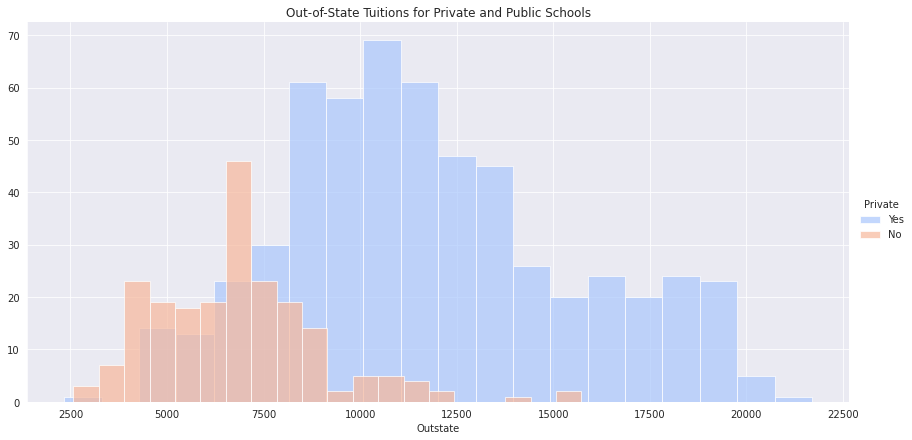

In [18]:
# Stacked histogram showing Out of State Tuition based on the Private column using sns.FacetGrid

# Plot template
sns.set_style('darkgrid')
g = sns.FacetGrid(df, hue='Private', palette='coolwarm', height=6, aspect=2)
# Apply histogram to each facet’s subset of the data (private vs. public university)
g = g.map(plt.hist,'Outstate', bins=20, alpha=0.7)
g = g.add_legend()
plt.title('Out-of-State Tuitions for Private and Public Schools')
plt.show()

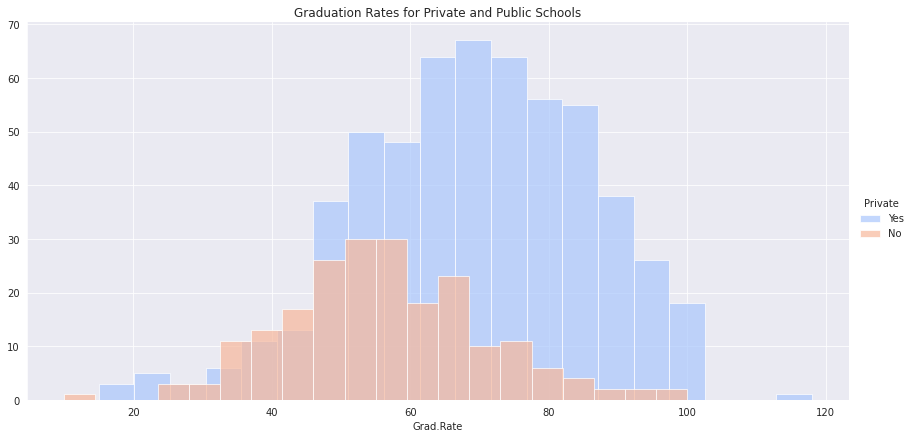

In [19]:
# Create similar histogram for graduation rate
g = sns.FacetGrid(data=df, hue='Private', palette='coolwarm', height=6, aspect=2)
g = g.map(plt.hist, 'Grad.Rate', bins=20, alpha=0.7)
g = g.add_legend()
plt.title('Graduation Rates for Private and Public Schools')
plt.show()

There's a private school with a graduation rate higher than 100%... investigate this.

In [65]:
df[df['Grad.Rate']>100]

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Cazenovia College,Yes,3847,3433,527,9,35,1010,12,9384,4840,600,500,22,47,14.3,20,7697,118


Set the graduation rate to 100% so that it makes sense.

In [66]:
df.loc['Cazenovia College', 'Grad.Rate'] = 100

In [67]:
df[df['Grad.Rate']>100]

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate


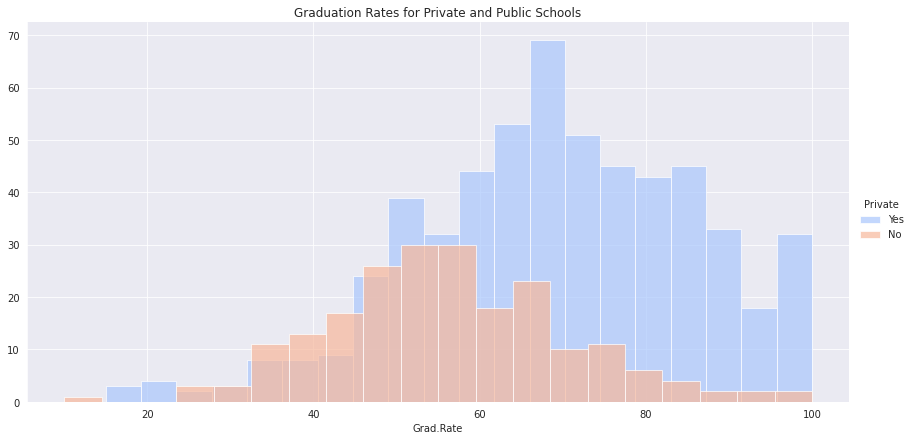

In [68]:
# Redo histogram to confirm
g = sns.FacetGrid(data=df, hue='Private', palette='coolwarm', height=6, aspect=2)
g = g.map(plt.hist, 'Grad.Rate', bins=20, alpha=0.7)
g = g.add_legend()
plt.title('Graduation Rates for Private and Public Schools')
plt.show()

## Train K-means model with 2 clusters

Although we usually do not have labels provided for clustering, in this example, we do (private vs. public). So we'll train a model with 2 clusters and see how that compares to the actual data. 

There is no perfect way to evaluate clustering because we usually do not have access to real labels.

In [143]:
# Instantiate model object
kmeans = KMeans(n_clusters=2, init='k-means++')
# Drop target variable (there should be no labels for unsupervised learning)
kmeans.fit(df.drop('Private', axis=1))
kmeans.cluster_centers_

array([[1.03631389e+04, 6.55089815e+03, 2.56972222e+03, 4.14907407e+01,
        7.02037037e+01, 1.30619352e+04, 2.46486111e+03, 1.07191759e+04,
        4.64347222e+03, 5.95212963e+02, 1.71420370e+03, 8.63981481e+01,
        9.13333333e+01, 1.40277778e+01, 2.00740741e+01, 1.41705000e+04,
        6.75925926e+01, 1.00000000e+00, 3.14814815e-01],
       [1.81323468e+03, 1.28716592e+03, 4.91044843e+02, 2.53094170e+01,
        5.34708520e+01, 2.18854858e+03, 5.95458894e+02, 1.03957085e+04,
        4.31136472e+03, 5.41982063e+02, 1.28033632e+03, 7.04424514e+01,
        7.78251121e+01, 1.40997010e+01, 2.31748879e+01, 8.93204634e+03,
        6.50926756e+01, 8.04911693e-16, 7.93721973e-01]])

In [144]:
# See predicted label count
df['Predicted Cluster'] = kmeans.labels_
df['Predicted Cluster'].value_counts()

1    669
0    108
Name: Predicted Cluster, dtype: int64

In [142]:
# See actual label count
df['Private'].value_counts()

Yes    565
No     212
Name: Private, dtype: int64

In [145]:
# Get features list
features = df.iloc[:,1:].columns.tolist()

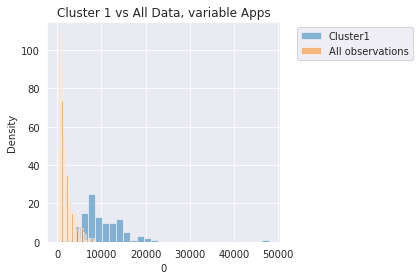

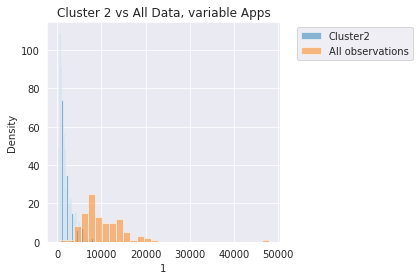

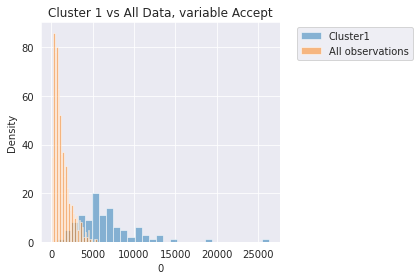

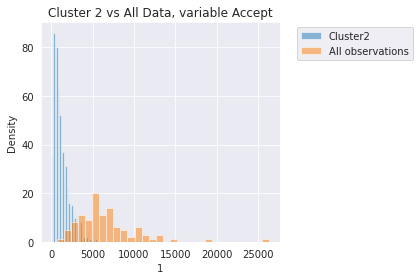

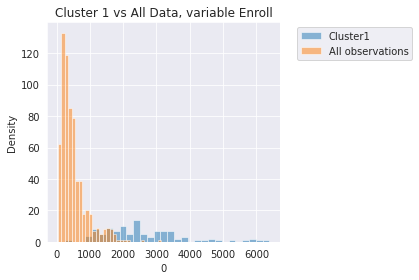

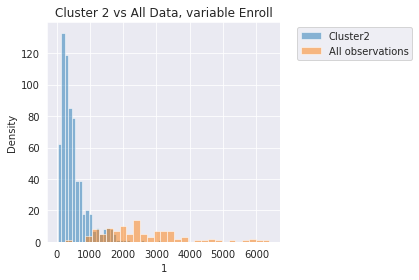

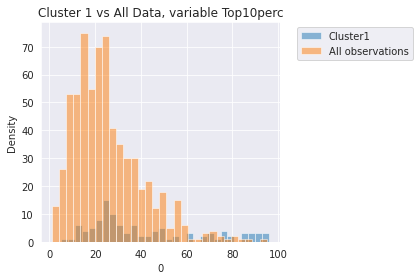

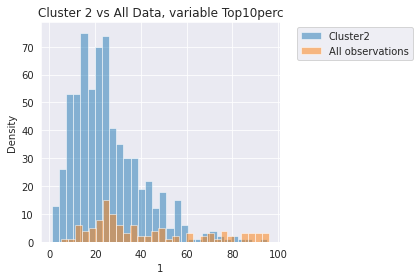

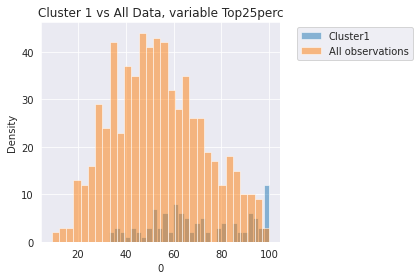

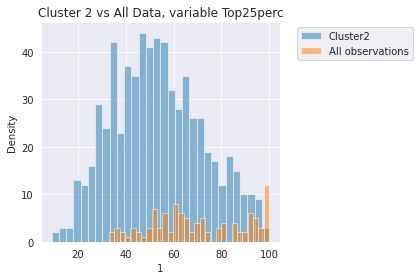

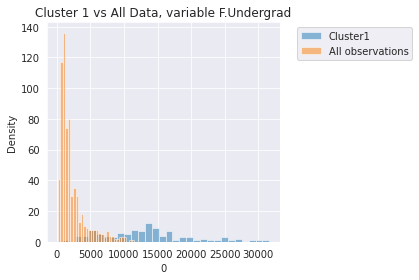

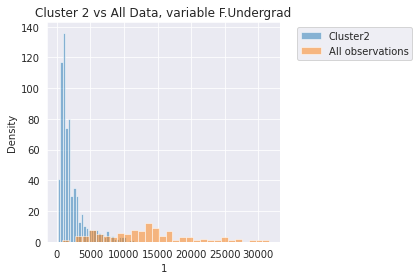

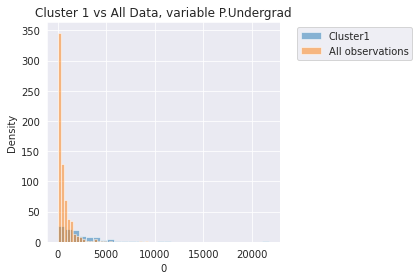

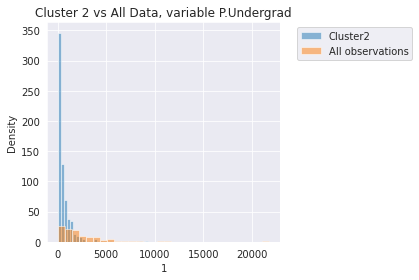

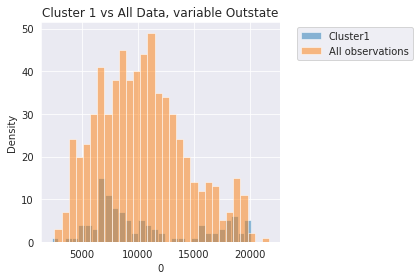

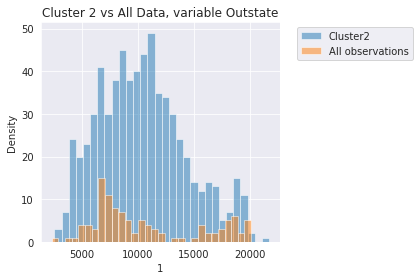

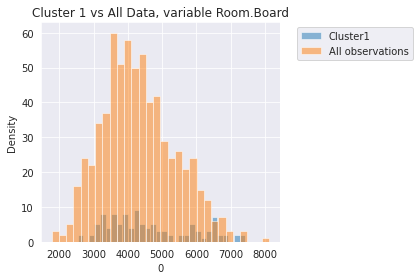

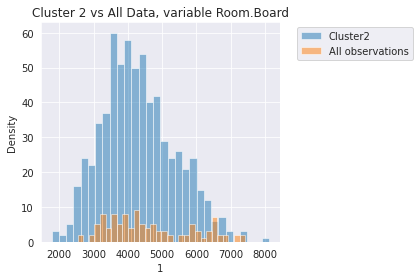

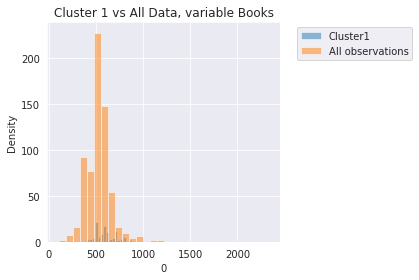

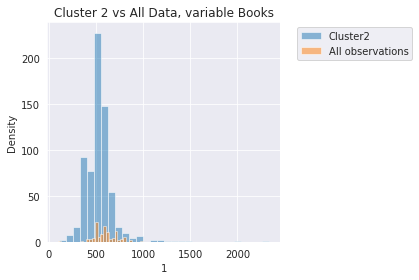

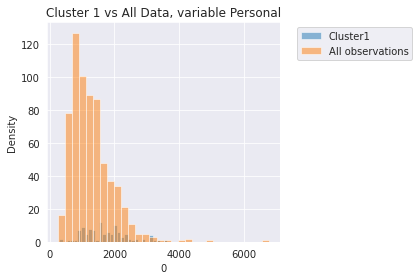

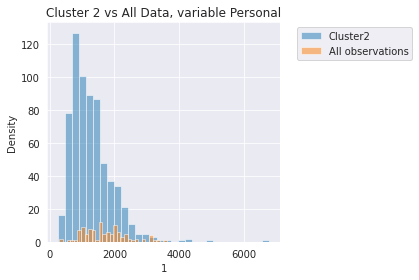

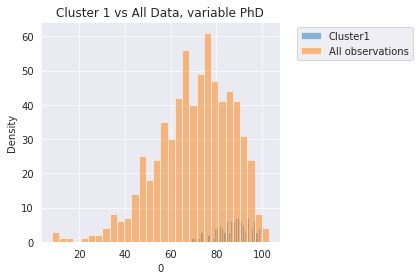

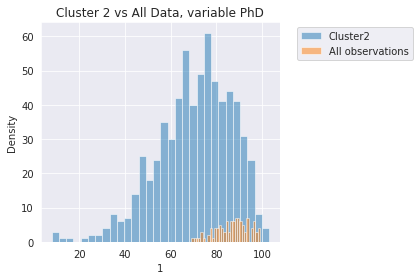

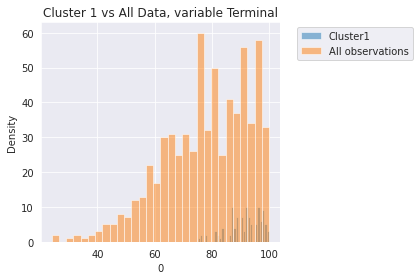

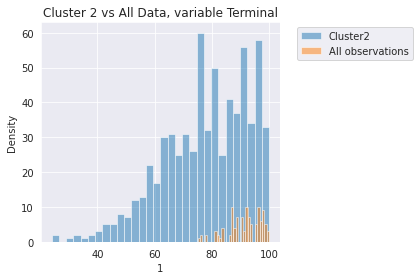

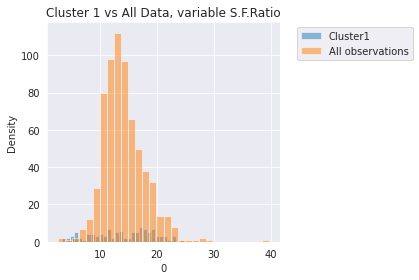

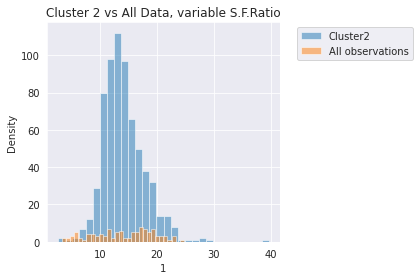

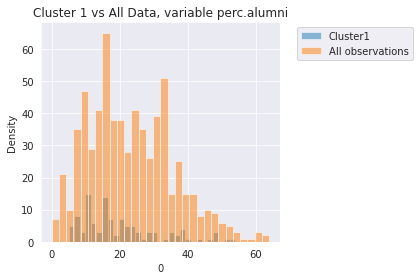

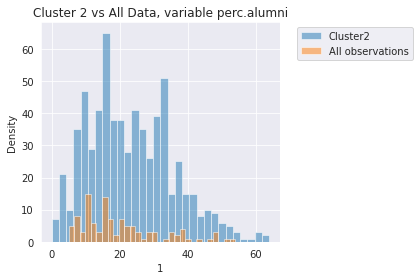

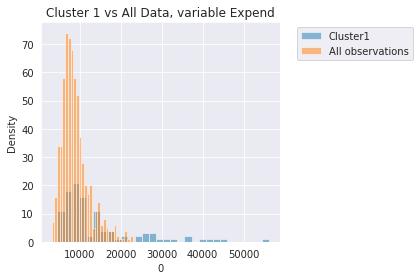

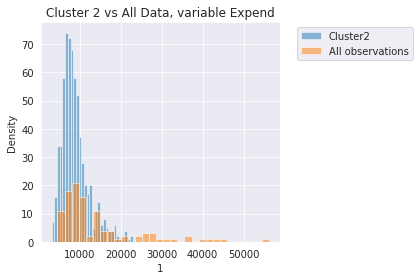

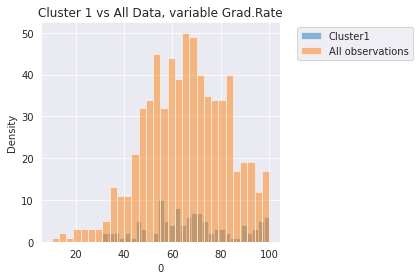

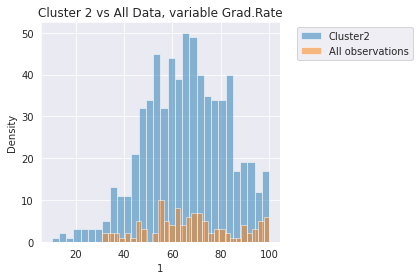

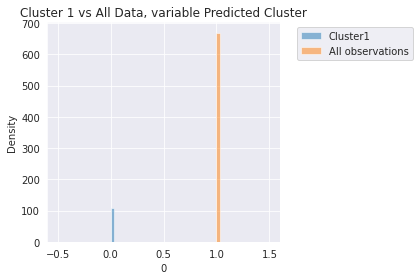

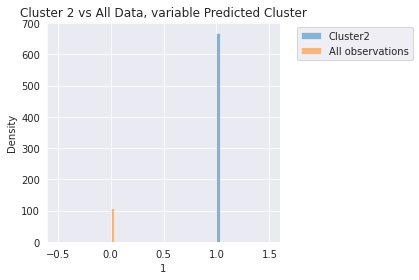

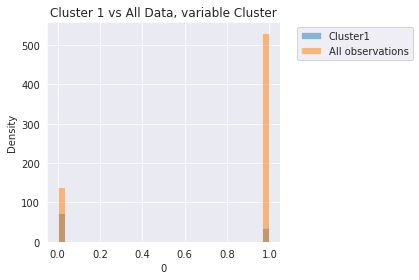

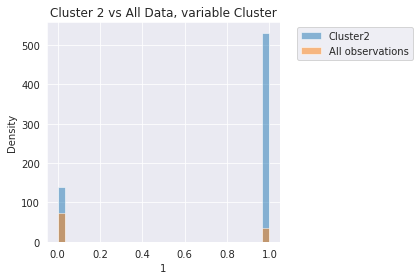

In [146]:
# Profile variables
clusterProfile(df, 'Predicted Cluster', features)

In [147]:
# Convert Private column to binary values
def converter(cluster):
    if cluster=='Yes':
        return 1
    else:
        return 0

df['Cluster'] = df['Private'].apply(converter)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Predicted Cluster,Cluster
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1,1
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1,1
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1,1
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1,1
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1,1


Create a confusion matrix and classification report to see how well the Kmeans clustering worked without being given any labels.

In [148]:
# See metrics
print(confusion_matrix(df['Cluster'], kmeans.labels_))
print(classification_report(df['Cluster'], kmeans.labels_))
print(accuracy_score(df['Cluster'], kmeans.labels_))

[[ 74 138]
 [ 34 531]]
              precision    recall  f1-score   support

           0       0.69      0.35      0.46       212
           1       0.79      0.94      0.86       565

    accuracy                           0.78       777
   macro avg       0.74      0.64      0.66       777
weighted avg       0.76      0.78      0.75       777

0.7786357786357786
